# Cochrane and Piazzesi

Cochrane and Piazzesi (2005) study how expected excess returns on U.S. Treasury bonds move over time. With Fama–Bliss zero-coupon yields from 1964 to 2003 they show that one specific mix of forward rates — a “tent-shaped” combo — explains most of the predictable movement in one-year excess returns.

What we replicate and why

- Figure 1. Shows the one-factor (tent-shape) structure across maturities.

- Table 4. Compares the CP factor to simple, standard alternatives like level, slope, curvature and common spreads. This tells us the CP factor adds information that those do not.

- Table 5. Adds a few monthly lags of the same factor and pushes the in-sample R^2 up to about 0.44. This shows the signal is persistent and economically large.

We focus on these because together they deliver the main message with the least machinery. We skip heavy simulation tests that add complexity but little extra insight for a replication.

Datasets and windows

- Fama–Bliss (FB). Bootstrapped zero-coupon curve. This is our baseline because it matches the original paper.

- GSW. Federal Reserve’s smooth fitted curve. Useful to check that results are not driven by FB construction noise and to extend beyond 2003.

- LW. A third independent curve. Helps confirm that the pattern is not dataset-specific.

In [1]:
# Libraries and imports
import sys
sys.path.append("replikering_python")  

from utils.data_processing import (load_wrds_famabliss, load_fed_gsw_daily_yields, load_lw_daily_yields)

from utils.paper_utils.CP_utils import (cp_tent_shaped_regression,
replicate_cp_table5, show_cp_table5, replicate_cp_table4, show_cp_table4)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import Dict, Tuple
from IPython.display import display, Markdown

1. Is the tent shape robust across sub-periods and across different data sets? 2. Is the tent-shaped return-predicting factor in some way similar to the traditional slope factor? Is it adding something to the slope explanation, or is it telling an altogether different story? 3. Can one give an economic interpretation to the tent factor? Can one link it to the business-cycles periodicity, or to macroeconomic variables?  Core terms of use, available at https://www.cambridge.org/core/terms. https://doi.org/10.1017/9781316694169.031  Downloaded from https://www.cambridge.org/core. University of Sydney Library, on 30 May 2018 at 05:01:44, subject to the Cambridge 478 Excess Returns: The Recent Literature – I  4. Are the differences in prediction between the tent and the slope returnpredicting factor robust? (By posing this question we ask whether the ‘extra information’ in the tent factor performs well out-of-sample.) 5. It is common knowledge that three principal components describe the yield curve very accurately. How can it be that five principal components are needed in order to account for the excess returns?

## Loading data 

In [2]:
df_fb = load_wrds_famabliss("data/wrds_famabliss.csv", sample_start="1964-01", sample_end="2003-12")
df_gsw = load_fed_gsw_daily_yields("data/FED_GSW_daily.csv", start="1964-01", end="2003-12")
df_lw = load_lw_daily_yields("data/LW_daily.csv", start="1964-01", end="2003-12")

print(df_fb.head())
print(df_gsw.head())
print(df_lw.head())

df_fb_ext = load_wrds_famabliss("data/wrds_famabliss.csv", sample_start="1977-01", sample_end="2016-12")
df_gsw_ext = load_fed_gsw_daily_yields("data/FED_GSW_daily.csv", start="1977-01", end="2016-12")
df_lw_ext = load_lw_daily_yields("data/LW_daily.csv", start="1977-01", end="2016-12")



Loaded WRDS Fama-Bliss data: (480, 5)
Date range: 1964-01-31 00:00:00 to 2003-12-31 00:00:00
Available maturities: ['y1', 'y2', 'y3', 'y4', 'y5']


/Users/trineberntsensaether/Library/CloudStorage/OneDrive-NTNU/25-26_ Olav, Ulrik & Trine - Replikering/replikering_python/utils/data_processing.py:292: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


TTERMTYPE         y1        y2        y3        y4        y5
MCALDT                                                      
1964-01-31  0.037893  0.038930  0.039386  0.039429  0.039839
1964-02-29  0.039474  0.039811  0.040249  0.040103  0.040230
1964-03-31  0.039105  0.040764  0.041250  0.041449  0.040727
1964-04-30  0.037829  0.039781  0.040473  0.040822  0.040769
1964-05-31  0.038323  0.039181  0.039642  0.040211  0.039793
               y1        y2        y3        y4        y5
Date                                                     
1964-01  0.035166  0.037619  0.038962  0.039685  0.040123
1964-02  0.036469  0.039031  0.039913  0.040354  0.040618
1964-03  0.037582  0.039989  0.040797  0.041200  0.041443
1964-04  0.036066  0.038582  0.039880  0.040585  0.041013
1964-05  0.036202  0.038414  0.039479  0.040066  0.040428
               y1        y2        y3        y4        y5
1964-01  0.037198  0.038495  0.038942  0.039617  0.039823
1964-02  0.038299  0.039478  0.039731  0.040281  0.

/Users/trineberntsensaether/Library/CloudStorage/OneDrive-NTNU/25-26_ Olav, Ulrik & Trine - Replikering/replikering_python/utils/data_processing.py:292: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


# Replication of Figure 1 and Table 5 in Cochrane and Piazzesi (2005)

## Fama-Bliss dataset: 1964-01 - 2003-12

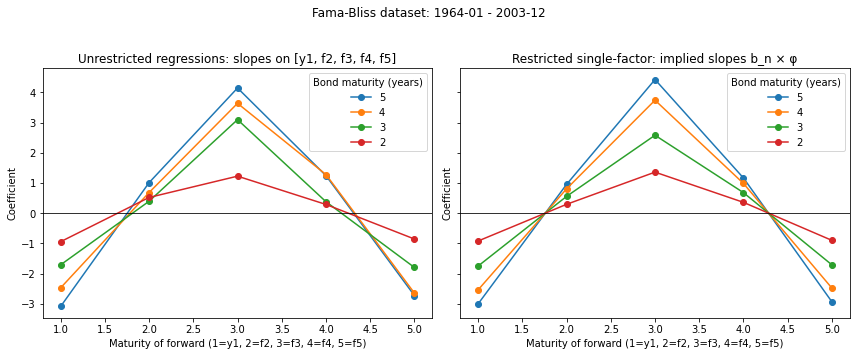

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.03,-2.06,0.65,3.03,0.80,-2.01,0.35
1,-0.03,-2.37,0.95,3.71,1.18,-3.07,0.40
2,-0.03,-2.49,1.19,3.51,1.78,-3.60,0.42
3,-0.03,-2.54,1.29,3.40,2.19,-3.95,0.44


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,8.14,NaN,NaN,NaN
1,0.50,0.50,NaN,NaN,8.89,6.51,NaN,NaN
2,0.38,0.35,0.28,NaN,6.82,6.43,4.38,NaN
3,0.30,0.29,0.20,0.2,4.67,7.24,4.55,2.99


## Fama-Bliss dataset: 1977-01 - 2016-12

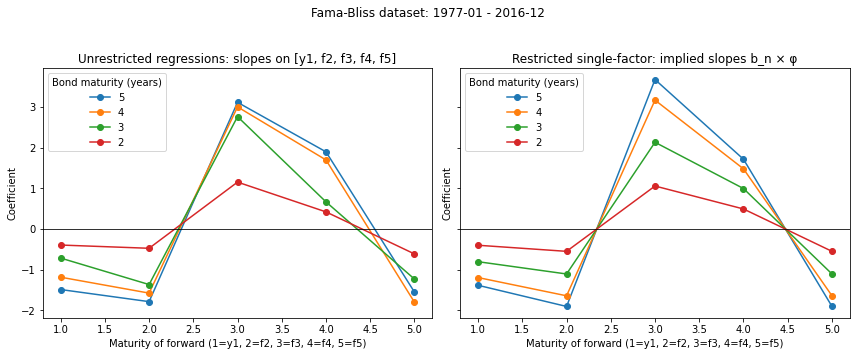

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.01,-0.94,-1.30,2.51,1.17,-1.30,0.20
1,-0.01,-0.86,-1.81,3.04,1.76,-2.02,0.24
2,-0.01,-0.80,-1.89,2.76,2.46,-2.41,0.25
3,-0.01,-0.73,-2.00,2.54,2.99,-2.67,0.26


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,4.70,NaN,NaN,NaN
1,0.50,0.50,NaN,NaN,4.97,3.88,NaN,NaN
2,0.38,0.35,0.27,NaN,4.33,4.48,2.46,NaN
3,0.28,0.30,0.21,0.21,2.98,4.61,2.85,1.83


In [3]:
display(Markdown("## Fama-Bliss dataset: 1964-01 - 2003-12"))
cp_tent_shaped_regression(df_fb, "Fama-Bliss dataset: 1964-01 - 2003-12")
cp_reg_coeff_with_lags = replicate_cp_table5(df_fb)
show_cp_table5(cp_reg_coeff_with_lags, title = "Fama-Bliss dataset: 1964-01 - 2003-12")

display(Markdown("## Fama-Bliss dataset: 1977-01 - 2016-12"))
cp_tent_shaped_regression(df_fb_ext, "Fama-Bliss dataset: 1977-01 - 2016-12")
cp_reg_coeff_with_lags1 = replicate_cp_table5(df_fb_ext)
show_cp_table5(cp_reg_coeff_with_lags1, title = "Fama-Bliss dataset: 1977-01 - 2016-12")

## Fama-Bliss dataset: 1964-01 - 2003-12

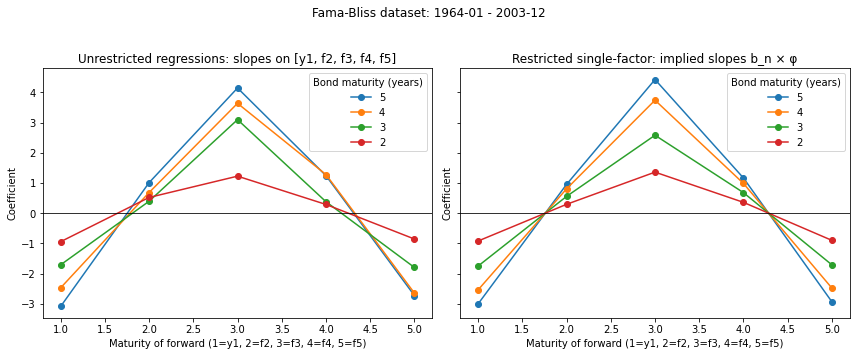

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.03,-2.06,0.65,3.03,0.80,-2.01,0.35
1,-0.03,-2.37,0.95,3.71,1.18,-3.07,0.40
2,-0.03,-2.49,1.19,3.51,1.78,-3.60,0.42
3,-0.03,-2.54,1.29,3.40,2.19,-3.95,0.44


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,8.14,NaN,NaN,NaN
1,0.50,0.50,NaN,NaN,8.89,6.51,NaN,NaN
2,0.38,0.35,0.28,NaN,6.82,6.43,4.38,NaN
3,0.30,0.29,0.20,0.2,4.67,7.24,4.55,2.99


## Fama-Bliss dataset: 1977-01 - 2016-12

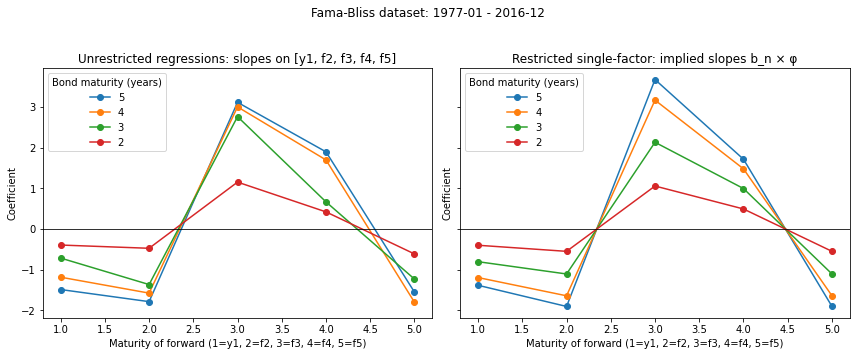

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.01,-0.94,-1.30,2.51,1.17,-1.30,0.20
1,-0.01,-0.86,-1.81,3.04,1.76,-2.02,0.24
2,-0.01,-0.80,-1.89,2.76,2.46,-2.41,0.25
3,-0.01,-0.73,-2.00,2.54,2.99,-2.67,0.26


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,4.70,NaN,NaN,NaN
1,0.50,0.50,NaN,NaN,4.97,3.88,NaN,NaN
2,0.38,0.35,0.27,NaN,4.33,4.48,2.46,NaN
3,0.28,0.30,0.21,0.21,2.98,4.61,2.85,1.83


In [4]:
display(Markdown("## Fama-Bliss dataset: 1964-01 - 2003-12"))
cp_tent_shaped_regression(df_fb, "Fama-Bliss dataset: 1964-01 - 2003-12")
cp_reg_coeff_with_lags = replicate_cp_table5(df_fb)
show_cp_table5(cp_reg_coeff_with_lags, title = "Fama-Bliss dataset: 1964-01 - 2003-12")

display(Markdown("## Fama-Bliss dataset: 1977-01 - 2016-12"))
cp_tent_shaped_regression(df_fb_ext, "Fama-Bliss dataset: 1977-01 - 2016-12")
cp_reg_coeff_with_lags1 = replicate_cp_table5(df_fb_ext)
show_cp_table5(cp_reg_coeff_with_lags1, title = "Fama-Bliss dataset: 1977-01 - 2016-12")

## GSW dataset: 1964-01 - 2003-12

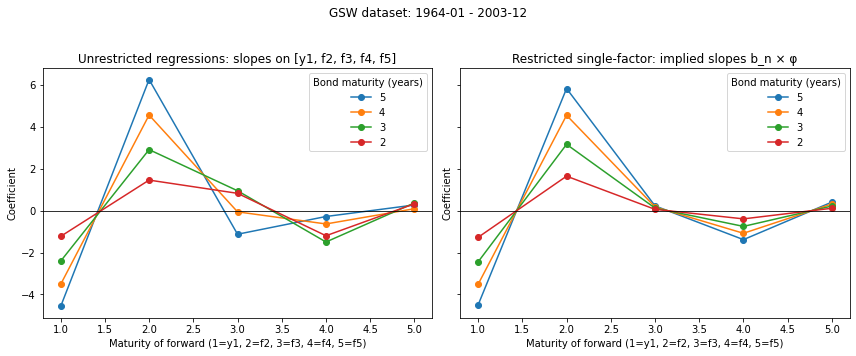

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.03,-2.93,3.80,0.15,-0.90,0.27,0.24
1,-0.03,-3.11,3.49,2.54,-3.82,1.29,0.26
2,-0.03,-3.03,2.26,6.23,-7.71,2.65,0.26
3,-0.03,-2.89,0.36,11.90,-13.81,4.85,0.26


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,4.68,NaN,NaN,NaN
1,0.47,0.53,NaN,NaN,2.50,2.55,NaN,NaN
2,0.45,0.33,0.23,NaN,2.46,3.01,1.06,NaN
3,0.41,0.30,0.04,0.25,2.31,2.95,0.46,1.1


## GSW dataset: 1977-01 - 2016-12

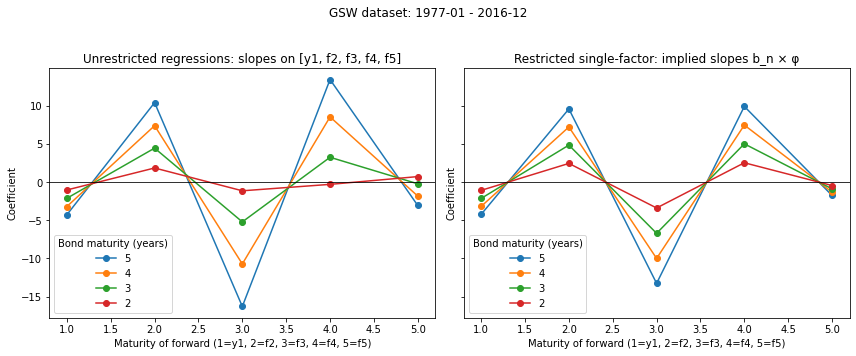

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.01,2.66,-6.03,8.35,-6.24,1.10,0.14
1,-0.01,2.92,-6.99,10.01,-7.75,1.66,0.15
2,-0.01,2.91,-7.06,10.34,-8.22,1.88,0.15
3,-0.01,2.92,-7.38,11.46,-9.64,2.48,0.15


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,-1.00,NaN,NaN,NaN,-3.03,NaN,NaN,NaN
1,-0.55,-0.45,NaN,NaN,-1.88,-1.21,NaN,NaN
2,-0.56,-0.54,0.10,NaN,-1.92,-3.28,0.26,NaN
3,-0.58,-0.53,-0.01,0.12,-1.83,-3.06,-0.06,0.29


In [5]:
display(Markdown("## GSW dataset: 1964-01 - 2003-12"))
cp_tent_shaped_regression(df_gsw, "GSW dataset: 1964-01 - 2003-12")
cp_reg_coeff_with_lags = replicate_cp_table5(df_gsw)
show_cp_table5(cp_reg_coeff_with_lags, title = "GSW dataset: 1964-01 - 2003-12")

display(Markdown("## GSW dataset: 1977-01 - 2016-12"))
cp_tent_shaped_regression(df_gsw_ext, "GSW dataset: 1977-01 - 2016-12")
cp_reg_coeff_with_lags1 = replicate_cp_table5(df_gsw_ext)
show_cp_table5(cp_reg_coeff_with_lags1, title = "GSW dataset: 1977-01 - 2016-12")

## LW dataset: 1977-01 - 2016-12

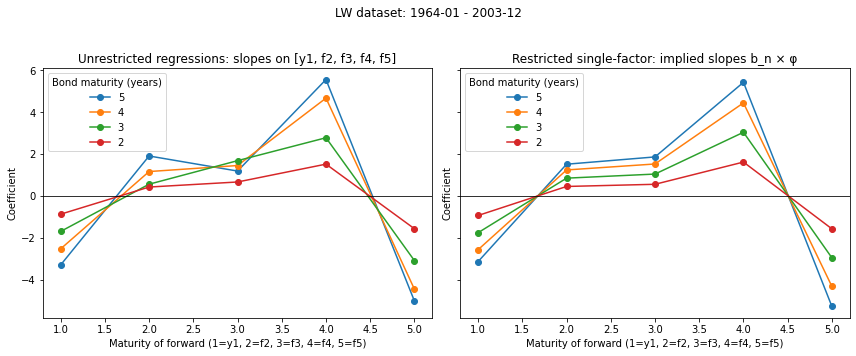

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,-0.02,-2.10,1.01,1.25,3.63,-3.53,0.31
1,-0.02,-2.20,1.05,1.04,5.12,-4.80,0.34
2,-0.02,-2.20,1.08,0.65,5.99,-5.33,0.35
3,-0.02,-2.23,1.23,0.15,6.85,-5.84,0.36


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,6.65,NaN,NaN,NaN
1,0.50,0.50,NaN,NaN,6.68,4.05,NaN,NaN
2,0.41,0.35,0.25,NaN,5.57,4.66,2.5,NaN
3,0.35,0.29,0.13,0.23,4.64,4.42,2.2,2.45


## LW dataset: 1977-01 - 2016-12

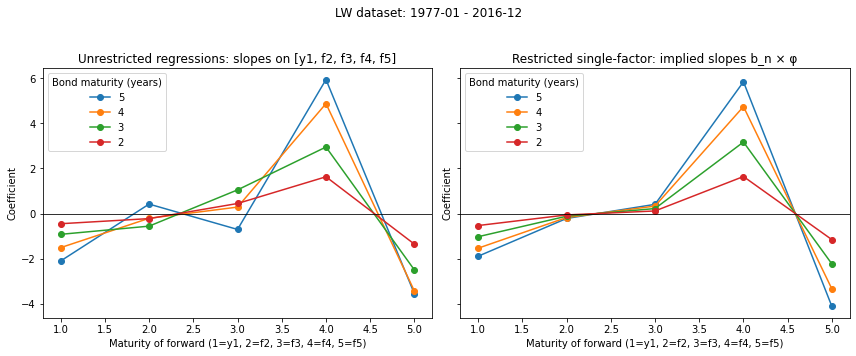

#### Additional Lags — Panel A: γ estimates

,const,y1,f2,f3,f4,f5,R2
k,,,,,,,
0,0.0,-1.25,-0.14,0.27,3.85,-2.72,0.19
1,0.0,1.32,-0.00,0.36,-5.28,3.64,0.22
2,0.0,1.33,-0.11,0.89,-6.15,4.09,0.23
3,0.0,1.38,-0.34,1.52,-6.95,4.47,0.24


#### Additional Lags — Panel B: α estimates and t-statistics

,alpha0,alpha1,alpha2,alpha3,t(alpha0),t(alpha1),t(alpha2),t(alpha3)
k,,,,,,,,
0,1.00,NaN,NaN,NaN,4.43,NaN,NaN,NaN
1,-0.46,-0.54,NaN,NaN,-4.35,-3.12,NaN,NaN
2,-0.38,-0.35,-0.28,NaN,-4.23,-3.68,-2.08,NaN
3,-0.32,-0.30,-0.15,-0.23,-3.77,-3.63,-1.77,-1.92


In [6]:
display(Markdown("## LW dataset: 1977-01 - 2016-12"))
cp_tent_shaped_regression(df_lw, "LW dataset: 1964-01 - 2003-12")
cp_reg_coeff_with_lags = replicate_cp_table5(df_lw)
show_cp_table5(cp_reg_coeff_with_lags, title = "LW dataset: 1964-01 - 2003-12")


display(Markdown("## LW dataset: 1977-01 - 2016-12"))
cp_tent_shaped_regression(df_lw_ext, "LW dataset: 1977-01 - 2016-12")
cp_reg_coeff_with_lags1 = replicate_cp_table5(df_lw_ext)
show_cp_table5(cp_reg_coeff_with_lags1, title = "LW dataset: 1977-01 - 2016-12")

# Replication of Table 4 in Cochrane and Piazzesi (2005)

In [7]:
res = replicate_cp_table4(df_fb, horizon_months=12, nw_lags=18)
show_cp_table4(res, title="Fama–Bliss dataset: 1964–2003")

### Fama–Bliss dataset: 1964–2003

In [8]:

res_fb_ext = replicate_cp_table4(df_fb_ext, horizon_months=12, nw_lags=18)
show_cp_table4(res_fb_ext, title="Fama–Bliss dataset: 1977–2016")

### Fama–Bliss dataset: 1977–2016

In [9]:
res_lw = replicate_cp_table4(df_lw, horizon_months=12, nw_lags=18)
show_cp_table4(res_lw, title="LW dataset: 1964–2003")

### LW dataset: 1964–2003

In [10]:

res_lw_ext = replicate_cp_table4(df_lw_ext, horizon_months=12, nw_lags=18)
show_cp_table4(res_lw_ext, title="LW dataset: 1977–2016")


### LW dataset: 1977–2016

In [11]:
res_gsw = replicate_cp_table4(df_gsw, horizon_months=12, nw_lags=18)
show_cp_table4(res_gsw, title="GSW dataset: 1964–2003")

### GSW dataset: 1964–2003

In [12]:

res_gsw_ext = replicate_cp_table4(df_gsw_ext, horizon_months=12, nw_lags=18)
show_cp_table4(res_gsw_ext, title="GSW dataset: 1977–2016")

### GSW dataset: 1977–2016